# Leer datasets

In [2]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wholesale_customers = fetch_ucirepo(id=292) 
  
# data (as pandas dataframes) 
X = wholesale_customers.data.features 
y = wholesale_customers.data.targets 
  
# metadata 
print(wholesale_customers.metadata) 
  
# variable information 
print(wholesale_customers.variables) 
print(X.head())
customer = X.copy()

{'uci_id': 292, 'name': 'Wholesale customers', 'repository_url': 'https://archive.ics.uci.edu/dataset/292/wholesale+customers', 'data_url': 'https://archive.ics.uci.edu/static/public/292/data.csv', 'abstract': 'The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 440, 'num_features': 7, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Region'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Mon Feb 05 2024', 'dataset_doi': '10.24432/C5030X', 'creators': ['Margarida Cardoso'], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': None, 'preprocessing_description':

# Realizamos los clusters

In [12]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering, AffinityPropagation, Birch, OPTICS, BisectingKMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer)
n_clusters = 3
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=n_clusters, random_state=42),
    'DBSCAN': DBSCAN(eps=0.9, min_samples=5),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=n_clusters),
}
results = {}
for name, algorithm in clustering_algorithms.items():
    try:
        algorithm.fit(customer_scaled)
        if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
        elif hasattr(algorithm, 'predict'):
            labels = algorithm.predict(customer_scaled)
        else:
            labels = algorithm.means_.argmax(axis=0)  # For GaussianMixture
        results[name] = labels
    except Exception as e:
        print(f"Error with {name}: {e}")

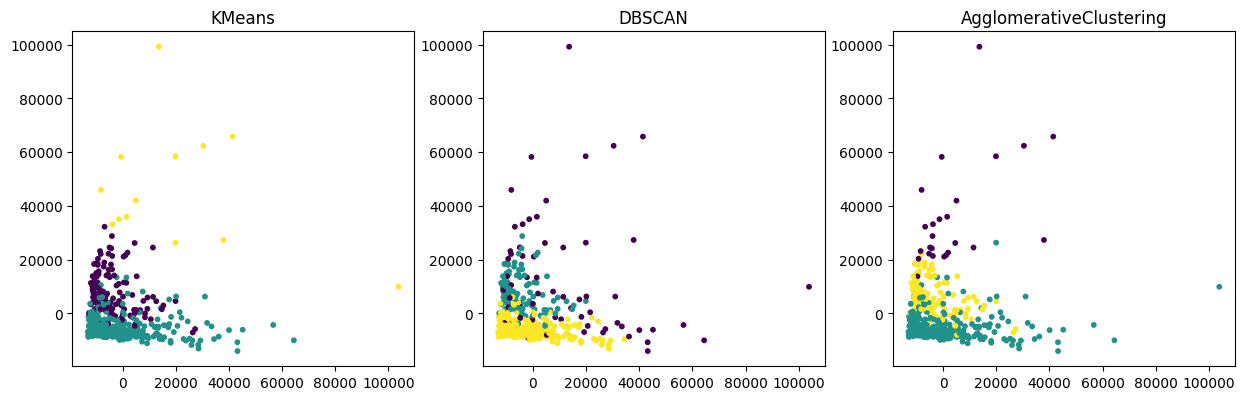

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
customer_pca = pca.fit_transform(customer)
plt.figure(figsize=(15, 20))
for i, (name, labels) in enumerate(results.items(), 1):
    plt.subplot(4, 3, i)
    plt.scatter(customer_pca[:, 0], customer_pca[:, 1], c=labels, cmap='viridis', s=10)
    plt.title(name)

In [14]:
#definimos dunn index
def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = data[labels == unique_labels[i]]
            cluster_j = data[labels == unique_labels[j]]
            inter_distance = np.linalg.norm(cluster_i.mean(axis=0) - cluster_j.mean(axis=0))
            inter_cluster_distances.append(inter_distance)

        intra_distance = np.mean([np.linalg.norm(data[labels == unique_label] - data[labels == unique_label].mean(axis=0)) for unique_label in unique_labels])
        intra_cluster_distances.append(intra_distance)

    dunn_index_value = min(inter_cluster_distances) / max(intra_cluster_distances)
    return dunn_index_value

In [15]:
#podrias generar una metrica en que se calcule el valor maximo de distancia (entre las menores distancias de cada punto con otro dentro del mismo cluster) dividido por el valor minimo de distancia entre cualquier punto de un cluster con otro punto de otro cluster
import numpy as np
from sklearn.metrics import pairwise_distances

def custom_metric(X, labels):
    X = np.array(X)
    distances = pairwise_distances(X)
    n = len(X)
    
    # Numerador: máximo de las mínimas distancias dentro del mismo cluster
    max_min_intra = -np.inf
    for i in range(n):
        same_cluster = (labels == labels[i])
        same_cluster[i] = False  # Exclude itself
        if np.any(same_cluster):
            min_dist = np.min(distances[i][same_cluster])
            max_min_intra = max(max_min_intra, min_dist)
    
    # Denominador: mínima distancia entre puntos de distintos clusters
    min_inter = np.inf
    for i in range(n):
        other_cluster = (labels != labels[i])
        if np.any(other_cluster):
            min_dist = np.min(distances[i][other_cluster])
            min_inter = min(min_inter, min_dist)

    M = max_min_intra / min_inter if min_inter != 0 else np.inf
    return 1 /( 1 + M)


In [16]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from permetrics import ClusteringMetric
def evaluate_clustering(data, labels):
    if len(set(labels)) < 2:
        return {
            'Silhouette Score': None,
            'Calinski-Harabasz Score': None,
            'Davies-Bouldin Score': None,
            'Dunn Index': None,
            'custom_metric': None,
            'dbcv': None
        }
    
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    dunn = dunn_index(data.values, labels)
    custom = custom_metric(data.values, labels)
    dbcv = ClusteringMetric(X=data.values, y_pred=labels).DBCVI()

    return {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Score': calinski_harabasz,
        'Davies-Bouldin Score': davies_bouldin,
        'Dunn Index': dunn,
        'custom_metric': custom,
        'dbcv': dbcv
    }
evaluation_results = {}
for name, labels in results.items():
    evaluation_results[name] = evaluate_clustering(customer, labels)
evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df = evaluation_df.rename(columns={
    'Silhouette Score': 'Silhouette',
    'Calinski-Harabasz Score': 'Calinski-Harabasz',
    'Davies-Bouldin Score': 'Davies-Bouldin',
    'Dunn Index': 'Dunn',
    'custom_metric': 'Custom Metric'
})
evaluation_df

/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv
KMeans,0.208649,105.053928,1.460003,0.075265,0.014395,0.995913
DBSCAN,0.191725,71.135778,1.982977,0.070516,0.025628,NaN
AgglomerativeClustering,0.153410,89.311659,1.614901,0.064949,0.018008,0.994854


In [17]:
#elige los mejores 3 resultados ponderando el orden de cada métrica
def weighted_score(row):
    weights = {
        'Silhouette': 0.2,
        'Calinski-Harabasz': -0.2,
        'Davies-Bouldin': 0.2,  # Negativo porque queremos minimizar
        'Dunn': 0.2,
        'Custom Metric': 0.5 # Puedes ajustar este peso según su importancia
    }
    score = (row['Silhouette'] * weights['Silhouette'] +
                1/(1+row['Calinski-Harabasz']) * weights['Calinski-Harabasz'] +
                1/(1+row['Davies-Bouldin']) * weights['Davies-Bouldin'] +
                row['Dunn'] * weights['Dunn'] +
                row['Custom Metric'] * weights['Custom Metric'])
    return score
# Replace None values with 0 for scoring
evaluation_df_filled = evaluation_df.fillna(0)
evaluation_df_filled['Weighted Score'] = evaluation_df_filled.apply(weighted_score, axis=1)
top_3_algorithms = evaluation_df_filled.nlargest(3, 'Weighted Score')
top_3_algorithms

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv,Weighted Score
KMeans,0.208649,105.053928,1.460003,0.075265,0.014395,0.995913,0.143395
DBSCAN,0.191725,71.135778,1.982977,0.070516,0.025628,0.000000,0.129537
AgglomerativeClustering,0.153410,89.311659,1.614901,0.064949,0.018008,0.994854,0.126946


# Interpretar

In [18]:
import sys
sys.path.append('../..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

Processing KMeans with 3 clusters
Ripper Accuracy for KMeans: 0.97
Ripper Rules:

Reglas para clase: 0
[[Channel=2^Detergents_Paper=4858.0-7803.9] V [Channel=2^Grocery=9134.9-12115.0] V [Channel=2^Grocery=12115.0-19741.7] V [Channel=2^Grocery=6599.8-9134.9] V [Channel=2^Grocery=4855.5-6599.8] V [Channel=2^Delicassen=<203.1] V [Channel=2^Fresh=969.6-2612.6] V [Channel=2^Fresh=4125.6-6135.2] V [Detergents_Paper=>7803.9^Fresh=2612.6-4125.6]]

Reglas para clase: 1
[[Channel=1]]

Reglas para clase: 2
[[Grocery=>19741.7^Fresh=8130.0-10532.2] V [Grocery=>19741.7^Fresh=>25975.5] V [Grocery=>19741.7^Frozen=855.7-1117.6^Milk=>12203.1]]
Decision Tree Accuracy for KMeans: 0.98


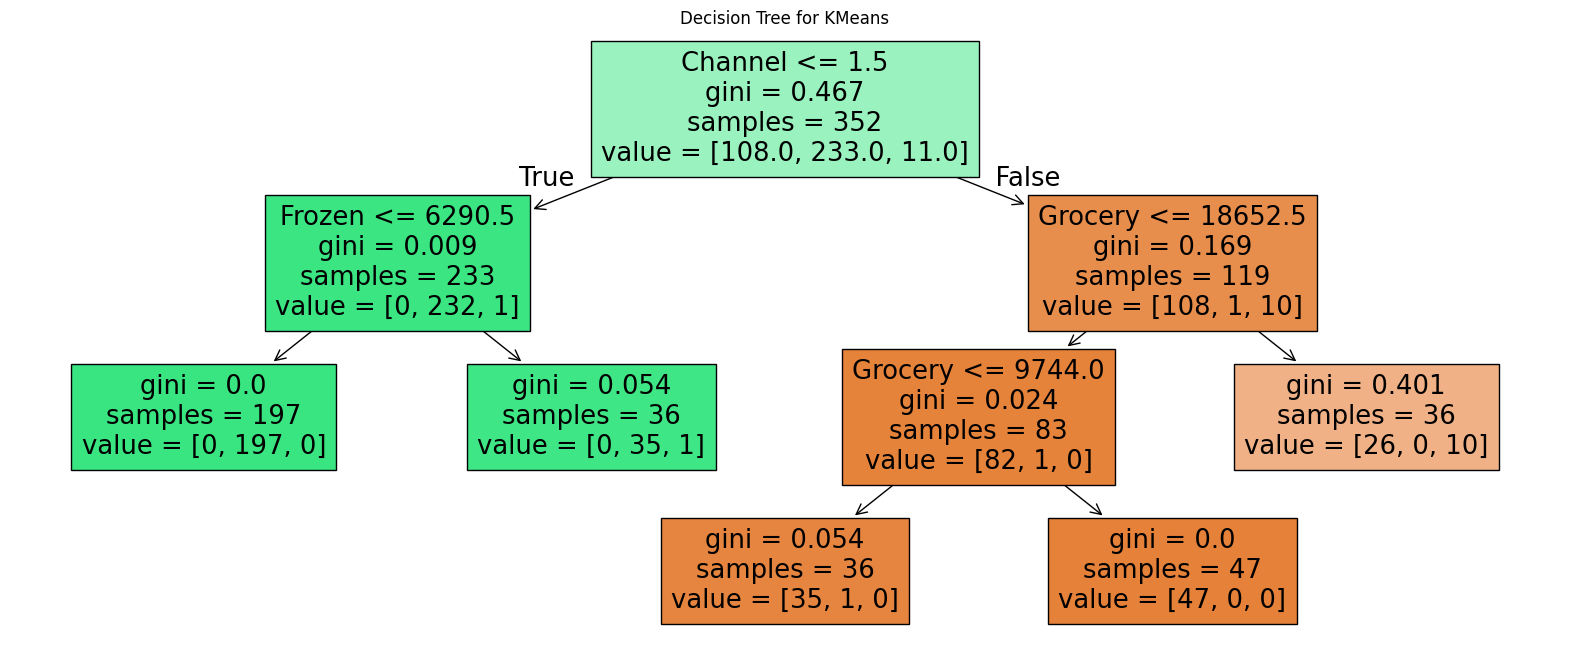

Optimization started

Training time: 13.62s, epochs: 200

Least training loss reached: 0.025
DSGD Accuracy for KMeans: 0.98
DSGD Rules:


Most important rules for class 0

	[0.759] R1: Channel = 2
			0: 0.691	1: 0.000	2: 0.144	Unc: 0.165

	[0.680] R15: -270.708 < Frozen < 2932.426
			0: 0.534	1: 0.331	2: 0.000	Unc: 0.135

	[0.499] R21: Detergents_Paper > 6436.778
			0: 0.365	1: 0.000	2: 0.318	Unc: 0.318

	[0.459] R2: Fresh < 3885.314
			0: 0.279	1: 0.475	2: 0.000	Unc: 0.245

	[0.416] R3: 3885.314 < Fresh < 11522.651
			0: 0.268	1: 0.377	2: 0.000	Unc: 0.355

	[0.411] R20: 3028.858 < Detergents_Paper < 6436.778
			0: 0.406	1: 0.011	2: 0.000	Unc: 0.584

	[0.410] R8: 5890.048 < Milk < 11068.862
			0: 0.347	1: 0.137	2: 0.000	Unc: 0.516

	[0.397] R12: 8166.241 < Grocery < 14933.749
			0: 0.341	1: 0.121	2: 0.000	Unc: 0.538

	[0.351] R4: 11522.651 < Fresh < 19159.987
			0: 0.257	1: 0.222	2: 0.000	Unc: 0.521

Most important rules for class 1

	[0.599] R2: Fresh < 3885.314
			0: 0.279	1: 0.475	2

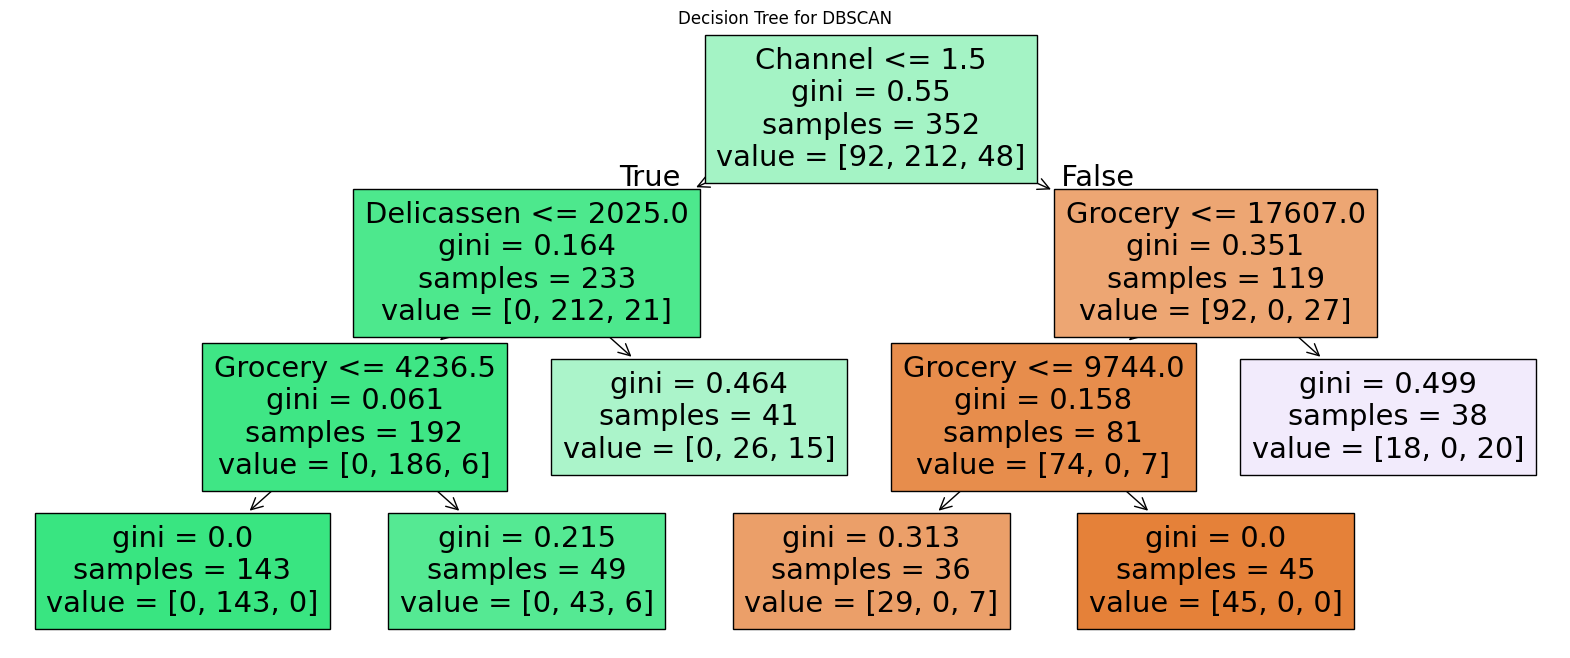

Optimization started

Training time: 13.55s, epochs: 200

Least training loss reached: 0.038
DSGD Accuracy for DBSCAN: 0.90
DSGD Rules:


Most important rules for class 0

	[0.863] R1: Channel = 2
			0: 0.767	1: 0.000	2: 0.205	Unc: 0.029

	[0.618] R9: Milk > 11068.862
			0: 0.382	1: 0.000	2: 0.618	Unc: 0.000

	[0.536] R12: 8166.241 < Grocery < 14933.749
			0: 0.450	1: 0.188	2: 0.000	Unc: 0.362

	[0.527] R20: 3028.858 < Detergents_Paper < 6436.778
			0: 0.513	1: 0.029	2: 0.000	Unc: 0.458

	[0.483] R8: 5890.048 < Milk < 11068.862
			0: 0.382	1: 0.227	2: 0.000	Unc: 0.391

	[0.443] R21: Detergents_Paper > 6436.778
			0: 0.410	1: 0.043	2: 0.026	Unc: 0.522

	[0.323] R23: -492.609 < Delicassen < 1570.219
			0: 0.191	1: 0.355	2: 0.000	Unc: 0.454

Most important rules for class 1

	[0.515] R0: Channel = 1
			0: 0.000	1: 0.515	2: 0.000	Unc: 0.485

	[0.490] R17: Frozen > 6135.560
			0: 0.000	1: 0.246	2: 0.730	Unc: 0.024

	[0.479] R10: Grocery < 1398.734
			0: 0.000	1: 0.479	2: 0.000	Unc: 0.521

	

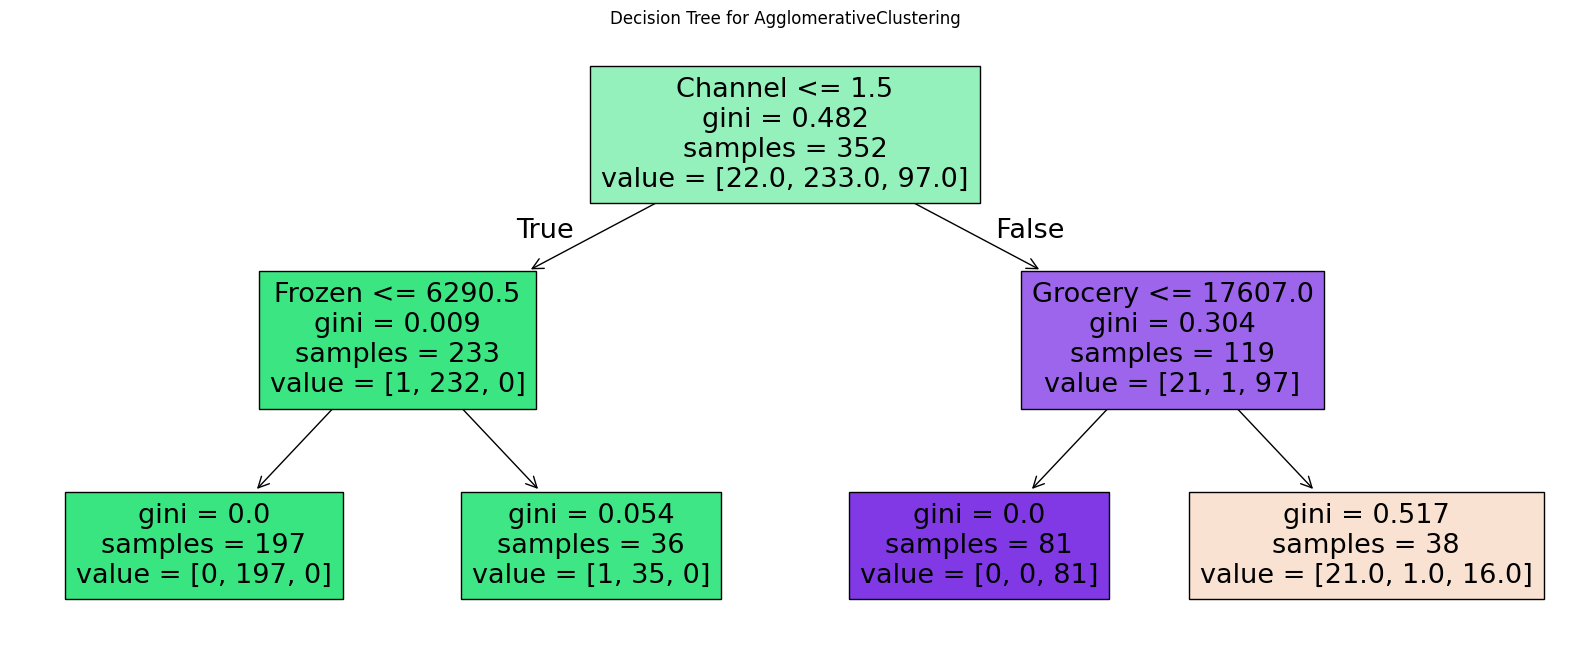

Optimization started

Training time: 13.84s, epochs: 200

Least training loss reached: 0.028
DSGD Accuracy for AgglomerativeClustering: 0.94
DSGD Rules:


Most important rules for class 0

	[0.758] R21: Detergents_Paper > 6436.778
			0: 0.697	1: 0.000	2: 0.128	Unc: 0.175

	[0.731] R25: Delicassen > 3633.047
			0: 0.610	1: 0.252	2: 0.014	Unc: 0.124

	[0.628] R13: Grocery > 14933.749
			0: 0.626	1: 0.005	2: 0.000	Unc: 0.369

	[0.513] R9: Milk > 11068.862
			0: 0.439	1: 0.006	2: 0.153	Unc: 0.401

Most important rules for class 1

	[0.610] R0: Channel = 1
			0: 0.000	1: 0.610	2: 0.000	Unc: 0.390

	[0.547] R6: Milk < 711.234
			0: 0.000	1: 0.547	2: 0.000	Unc: 0.453

	[0.538] R2: Fresh < 3885.314
			0: 0.000	1: 0.438	2: 0.223	Unc: 0.339

	[0.470] R25: Delicassen > 3633.047
			0: 0.610	1: 0.252	2: 0.014	Unc: 0.124

	[0.452] R16: 2932.426 < Frozen < 6135.560
			0: 0.000	1: 0.361	2: 0.204	Unc: 0.435

	[0.442] R23: -492.609 < Delicassen < 1570.219
			0: 0.000	1: 0.367	2: 0.165	Unc: 0.468

	[0.42

In [21]:
# interpretamos solo los mejores 3 resultados y guardamos los modelos
saved_models = {}
top_3_labels = {name: results[name] for name in top_3_algorithms.index}
top_3_data = customer.copy()
for name, labels in top_3_labels.items():
    n = len(np.unique(labels))
    X_train, X_test, y_train, y_test = train_test_split(top_3_data, labels, test_size=0.2, random_state=42)
    max_label = np.max(labels)
    y_train = np.where(y_train == -1, max_label + 1, y_train)
    y_test = np.where(y_test == -1, max_label + 1, y_test)
    print(f'Processing {name} with {n} clusters')
    
    # Ripper
    ripper = MultiClassRipperClassifier(random_state=43)
    ripper.fit(X_train, y_train)
    y_pred_ripper = ripper.predict(X_test)
    print(f'Ripper Accuracy for {name}: {accuracy_score(y_test, y_pred_ripper):.2f}')
    print('Ripper Rules:')
    ripper.print_rules()
    saved_models.setdefault(name, {})['ripper'] = ripper
    
    # Decision Tree
    dtree = DecisionTreeClassifier(random_state=42, max_depth=5, min_weight_fraction_leaf=0.1)
    dtree.fit(X_train, y_train)
    dtree_pred = dtree.predict(X_test)
    print(f'Decision Tree Accuracy for {name}: {accuracy_score(y_test, dtree_pred):.2f}')
    plt.figure(figsize=(20, 8))
    sk_tree.plot_tree(dtree, filled=True, feature_names=X_train.columns)
    plt.title(f'Decision Tree for {name}')
    plt.show()
    saved_models[name]['dtree'] = dtree
    
    # DSGD
    ds = DSClassifierMultiQ(n, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
    X = X_train.to_numpy()
    losses, epoch, dt = ds.fit(X, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X_train.columns)
    x_test = X_test.to_numpy()
    y_pred_ds = ds.predict(x_test)
    print(f'DSGD Accuracy for {name}: {accuracy_score(y_test, y_pred_ds):.2f}')
    print('DSGD Rules:')
    ds.print_most_important_rules(threshold=0.32)
    saved_models[name]['ds'] = ds
    
    print('--' * 40)